# Message Passing Interface

In python the library `mpi4py` provides all the functionalities of the **M**essage **P**assing **I**nterface (**MPI**). This notebook reviews essential commands:
* `comm = MPI.COMM_WORLD`: creates a communication world that contains the rank `rank = comm.Get_rank()`, size `size = comm.Get_size()`
* `comm.send(data, dest = i, tag = j)` to send `data` from process `j` to process `i`
* `data = comm.recv(source = i, tag = rank)` to receive dtata from process i
* `data = comm.bcast(data, root = rootrank)` to broadcast `data` from process `rootrank` to all other processes

The goal of this notebook is to parallelize a Lorenz attractor code with the following constraints:
* The code should read from an ASCII file the number of trajectories, the time of integration and the number of time steps
* Each realization of the code should yield a different answer
* The path, origin of individual trajectories, and parameters of the simulations should be saved in hdf5 files. Explore two options: one file per process vs one file for each simulation.


In [1]:
%%file hellompi.py
"""
Parallel Hello World
"""

from mpi4py import MPI
import sys
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
name = MPI.Get_processor_name() #optional only useful if running on different machines

sys.stdout.write(
    "Hello, I am process %d of %d on %s.\n" 
    % (rank, size, name))

Overwriting hellompi.py


In [2]:
!mpiexec -n 4 python hellompi.py

Hello, I am process 2 of 4 on belledonne.local.
Hello, I am process 1 of 4 on belledonne.local.
Hello, I am process 0 of 4 on belledonne.local.
Hello, I am process 3 of 4 on belledonne.local.


## Serial Lorenz code

The serial code uses 3 functions that are to be used in the parallel version. These functions parse an ascii file to retrieve the simulation's parameters, read and write trajectories in `hdf5` format.

In [3]:
%%file tools.py

import h5py
import numpy as np
from scipy import integrate
import time

def parser(inputfiledata,substring,datatype):
    for i in range(len(inputfiledata)):
        if inputfiledata[i].startswith(substring):
            if datatype == 'INT':
                data = np.int(inputfiledata[i][len(substring):-1])
            elif datatype == 'FLOAT':
                data = np.float(inputfiledata[i][len(substring):-1])
            else:
                print("parser function recognizes only 'INT and 'FLOAT' types")
    return data

def read_xt_file(fname):
    file = h5py.File(fname,"r+")
    x_t = file['x_t'][:]
    t = file['t'][:]
    N_trajectories = file['x_t'].attrs['Number of trajectories']
    Tintegration = file['x_t'].attrs['Integration time']
    Ntimesteps = file['x_t'].attrs['Number of time steps'] 
    return x_t,t,N_trajectories,Tintegration,Ntimesteps
def write_xt_file(fname,x_t,t,N_trajectories,Tintegration,Ntimesteps):
    file = h5py.File(fname,"w")
    xtset = file.create_dataset('x_t',data = x_t)
    xtset.attrs['Number of trajectories'] = N_trajectories
    xtset.attrs['Integration time'] = Tintegration
    xtset.attrs['Number of time steps'] = Ntimesteps
    tset = file.create_dataset('t',data = t)
    file.close()
    return

Overwriting tools.py


In [19]:
import h5py
import numpy as np
from scipy import integrate
import time

import tools as tls

inputfilename = "lorenz.in"
f = open('lorenz.in','r')
inputfile = f.readlines()
f.close()
N_trajectories = tls.parser(inputfile, "NUMBER OF TRAJECTORIES", "INT")
Tintegration = tls.parser(inputfile, "INTEGRATION TIME", "FLOAT")
Ntimesteps = tls.parser(inputfile, "NUMBER OF TIME STEPS", "INT")
sigma=10.; beta=8./3; rho=28.0
def lorenz_deriv(x,t0):
    global sigma, beta, rho
    """Compute the time-derivative of a Lorentz system."""
    return [sigma * (x[1] - x[0]), x[0] * (rho - x[2]) - x[1], x[0] * x[1] - beta * x[2]]

# def lorentz_deriv([x, y, z], t0, sigma=10., beta=8./3, rho=28.0):
#     """Compute the time-derivative of a Lorentz system."""
#     return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]


# Choose random starting points, uniformly distributed from -15 to 15
seed = np.int((time.time() - np.int(time.time()))*1e7)
print(seed)
np.random.seed(seed)
x0 = -15 + 30 * np.random.random((N_trajectories, 3))

# Solve for the trajectories
t = np.linspace(0, Tintegration, Ntimesteps)
x_t = np.asarray([integrate.odeint(lorenz_deriv, x0i, t)
                  for x0i in x0])

print(x_t.shape)
# fname = "mpi_p"+str(rank).zfill(2)+".h5"
fname = 'serial.h5'
tls.write_xt_file(fname,x_t,t,N_trajectories,Tintegration,Ntimesteps)

3325598
(20, 1000, 3)


## Plotting

The following routine is considered to be post-processing

In [5]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames

def plot_attractor(x_t):
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    # Data for a three-dimensional line
    for itraj in range(N_trajectories):


        ax.plot3D(x_t[itraj,:,0], x_t[itraj,:,1], x_t[itraj,:,2])
    plt.show()
    plt.close(fig)

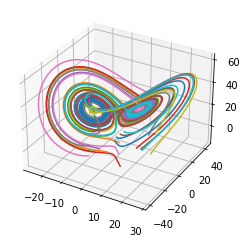

In [20]:
x_t,t,N_trajectories,Tintegration,Ntimesteps = tls.read_xt_file('serial.h5')
plot_attractor(x_t)

## Parallel code

In [21]:
%%file mpi_lorenz.py
import h5py
import numpy as np
from scipy import integrate
import time

import tools as tls
from mpi4py import MPI
import sys

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

if rank == 0:
    inputfilename = "lorenz.in"
    f = open('lorenz.in','r')
    inputfile = f.readlines()
    f.close()
    N_trajectories = tls.parser(inputfile, "NUMBER OF TRAJECTORIES", "INT")
    Tintegration = tls.parser(inputfile, "INTEGRATION TIME", "FLOAT")
    Ntimesteps = tls.parser(inputfile, "NUMBER OF TIME STEPS", "INT")
    seed = np.int((time.time() - np.int(time.time()))*1e8)
    np.random.seed(seed)
    x0_all = -15 + 30 * np.random.random((N_trajectories, 3))
    print(x0_all[:,0])
    # distribution of tasks
    N_traj_proc = N_trajectories // size
    nresidual = N_trajectories - N_traj_proc * size
    tasks_per_proc = np.zeros(size,dtype = 'int')
    if nresidual == 0:
        tasks_per_proc[:] = N_traj_proc       
    else: 
        tasks_per_proc[:-1] = N_traj_proc
        tasks_per_proc[-1] = N_trajectories - N_traj_proc*(size - 1)
#     tasks_per_proc = comm.bcast(tasks_per_proc, root = 0)
else:
    N_trajectories = None
    Tintegration = None
    Ntimesteps = None
    tasks_per_proc = None
    
tasks_per_proc = comm.bcast(tasks_per_proc, root = 0)    
my_N_Trajectories = tasks_per_proc[rank]    
N_trajectories = comm.bcast(N_trajectories, root = 0)
Tintegration = comm.bcast(Tintegration, root = 0)
Ntimesteps = comm.bcast(Ntimesteps, root = 0)
print("tasks_per_proc",rank,tasks_per_proc)
if rank == 0:
    my_x0 = x0_all[:tasks_per_proc[0],:]
    if size > 1:
        for ip in range(1,size):
            nori = np.sum(tasks_per_proc[:ip])
            nend = nori + tasks_per_proc[ip]
            comm.send(x0_all[nori:nend,:],dest=ip,tag=ip)
            print("send",rank, ip, nori,nend)
else:
    my_x0 = comm.recv(source=0,tag=rank)
    

print(rank,my_x0[:,0],len(my_x0[:,0]))
sys.stdout.write(
    "my rank %d, number of tasks %d \n" 
    % (rank, my_N_Trajectories))
# print(rank,N_trajectories,Tintegration,Ntimesteps)

sigma=10.; beta=8./3; rho=28.0
def lorenz_deriv(x,t0):
    global sigma, beta, rho
    """Compute the time-derivative of a Lorentz system."""
    return [sigma * (x[1] - x[0]), x[0] * (rho - x[2]) - x[1], x[0] * x[1] - beta * x[2]]
t = np.linspace(0, Tintegration, Ntimesteps)
x_t = np.asarray([integrate.odeint(lorenz_deriv, x0i, t)
                  for x0i in my_x0])

if rank == 0:
    xt_all = np.zeros((N_trajectories,Ntimesteps,3))
    xt_all[:tasks_per_proc[0],:,:] = np.copy(x_t)
    if size > 1:
        for ip in range(1,size):
            nori = np.sum(tasks_per_proc[:ip])
            nend = np.sum(tasks_per_proc[:ip+1])
            xt_all[nori:nend,:,:] = comm.recv(source = ip, tag = ip)
    fname = 'output.h5'
    tls.write_xt_file(fname,xt_all,t,N_trajectories,Tintegration,Ntimesteps)
else:
    comm.send(x_t, dest = 0, tag = rank)


Overwriting mpi_lorenz.py


In [22]:
int(20 / 3)

6

In [23]:
!mpirun -n 3 python mpi_lorenz.py

[ -3.37350678  -1.28198241  -8.39324116   8.89305049   9.74377477
  -8.48226974  -8.27722937   2.86935205   8.84973796  10.7999503
  -2.56206034 -10.00731695   2.34506322 -14.31346686   9.00942419
  13.03488341  -8.03997415  -5.81845062  10.46930457   7.26600713]
tasks_per_proc 0 [6 6 8]
tasks_per_proc 1 [6 6 8]
tasks_per_proc 2 [6 6 8]
send 0 1 6 12
send 0 2 12 20
1 [ -8.27722937   2.86935205   8.84973796  10.7999503   -2.56206034
 -10.00731695] 6
my rank 1, number of tasks 6 
0 [-3.37350678 -1.28198241 -8.39324116  8.89305049  9.74377477 -8.48226974] 6
my rank 0, number of tasks 6 
2 [  2.34506322 -14.31346686   9.00942419  13.03488341  -8.03997415
  -5.81845062  10.46930457   7.26600713] 8
my rank 2, number of tasks 8 


(20, 1000, 3)


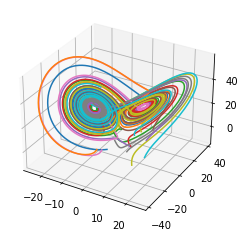

In [24]:
import tools as tls
x_t,t,N_trajectories,Tintegration,Ntimesteps = tls.read_xt_file('output.h5')
print(np.shape(x_t))
plot_attractor(x_t)

In [10]:
print(x_t[:,1,0])

[-11.17581201  -2.33881293   8.9831986  -13.26878407  -6.04807847
  12.98335584  -6.91608421  -9.27087887   2.0498751   -9.27897284
  12.32678126 -13.5726249   14.58488553  11.11181913  -8.81482121
   6.68110685  12.99648857  -8.67644712 -14.60386169  -4.29136552]
